<a href="https://colab.research.google.com/github/Odiniya/GTBank_Sentiment_Analysis/blob/main/GTBank_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-play-scraper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.2 MB/s eta 0:00:00


In [ ]:
!pip install transformers

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt


from transformers import TFAutoModelForSequenceClassification, AutoTokenizer


from google_play_scraper import reviews
from google.colab import drive

plt.style.use('ggplot')

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create folder for saving the CSV file
folder_path = '/content/drive/MyDrive/Colab Notebooks/GT_Bank_Sentiment_Analysis'
os.makedirs(folder_path, exist_ok=True)

In [ ]:
# GTBank GTWorld app ID from Google Play Store
app_id = 'com.gtbank.gtworldv1'

In [ ]:
# Function to scrape all reviews
def scrape_all_reviews(app_id):
    all_reviews = []
    continuation_token = None  # Initialize continuation token
    try:
        while True:
            # Scrape reviews with the continuation token
            reviews_batch, continuation_token = reviews(
                app_id,
                count=100,  # Number of reviews to fetch per request
                lang='en',   # Language: English
                country='ng', # Country: Nigeria
                continuation_token=continuation_token  # Use continuation token for pagination
            )
            if not reviews_batch:  # Stop if no more reviews are returned
                break

            all_reviews.extend(reviews_batch)  # Add the batch to all reviews
            print(f"Retrieved {len(reviews_batch)} reviews...")

    except Exception as e:
        print(f"An error occurred: {e}")

    return all_reviews

In [ ]:
# Scrape all reviews
app_reviews = scrape_all_reviews(app_id)

Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...
Retrieved 100 reviews...


In [ ]:
# Convert scraped reviews to a DataFrame
df = pd.DataFrame(app_reviews)

In [ ]:
# Save reviews to a CSV file in the specified folder
csv_file_path = os.path.join(folder_path, 'gtbank_reviews.csv')
df.to_csv(csv_file_path, index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GT_Bank_Sentiment_Analysis/gtbank_reviews.csv')

In [ ]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,e98a830d-6544-452a-8087-7200cb469c0c,Lawrence Makama,https://play-lh.googleusercontent.com/a-/ALV-U...,Awesome,5,0,6.0.0,2024-10-08 23:55:55,NaN,NaN,6.0.0
1,2f1ee6de-8840-4fda-b7f8-223b1dd84410,Kuti King,https://play-lh.googleusercontent.com/a-/ALV-U...,Very helpful,5,0,5.4.0,2024-10-08 23:18:03,NaN,NaN,5.4.0
2,e3d81af8-5da9-4bab-8153-d6c3d1c2a448,Suleiman Abdulwahid,https://play-lh.googleusercontent.com/a/ACg8oc...,"Very annoying app. Downloaded it, opened an ac...",1,0,NaN,2024-10-08 22:56:17,NaN,NaN,NaN
3,10428677-bbaa-4c10-954b-17161f81605a,Abdulkarim Aliyu,https://play-lh.googleusercontent.com/a/ACg8oc...,One of the best I have had in a while,5,0,6.0.0,2024-10-08 22:50:34,NaN,NaN,6.0.0
4,438ca552-05a4-449c-8bc4-8941a66c8f1b,Ashiru Yusuf,https://play-lh.googleusercontent.com/a/ACg8oc...,Excellent,5,0,6.0.0,2024-10-08 21:40:04,NaN,NaN,6.0.0


In [ ]:
df = df.head(10000)

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values

,0
reviewCreatedVersion,1272
replyContent,9638
repliedAt,9638
appVersion,1272


In [ ]:
df.shape

(10000, 11)

In [ ]:

# Fill missing values in 'reviewCreatedVersion'
df['reviewCreatedVersion'] = df['reviewCreatedVersion'].fillna(df['reviewCreatedVersion'].mode()[0])

# Fill missing values in 'appVersion'
df['appVersion'] = df['appVersion'].fillna(df['appVersion'].mode()[0])

# Fill 'replyContent' and 'repliedAt' with placeholders
df['replyContent'] = df['replyContent'].fillna('No Reply')

# Convert 'repliedAt' to string format before filling missing values (since it's a datetime field)
df['repliedAt'] = df['repliedAt'].astype(str).fillna('No Reply')


In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values

,0


In [ ]:
# Define a function to perform basic cleaning\
def basis_clean(text):
  # Remove URLs, special characters, and numbers
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # remove mentions and hashtags
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.strip()  # remove whitespaces
    return text

In [ ]:
# Apply the basic cleaning to the content
df['cleaned_content'] = df['content'].apply(basis_clean)

In [ ]:
# Load pre-trained BERT model and tokenizer from Hugging Face
checkpoint = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassific

In [ ]:
# Define Fuction to perform sentiment analysis
def bert_sentiment_analysis(text):
  inputs = tokenizer(text, return_tensors='tf', truncation=True, padding=True)
  outputs = model(**inputs)
  predictions = tf.nn.softmax(outputs.logits, axis=1)  # Apply softmax to get probabilities
  sentiment_score = tf.argmax(predictions, axis=1).numpy()[0] + 1  # Get sentiment score (1-5 scale)
  return sentiment_score

In [ ]:
# Apply the Bert model to all review content in the Dataframe
df['sentiment_score'] = df['cleaned_content'].apply(bert_sentiment_analysis)

In [ ]:
# Map sentiment score (1-5) to Positive, Neutral, Negative labels
def map_bert_sentiment(score):
    if score in [4, 5]:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

In [ ]:
df['sentiment'] = df['sentiment_score'].apply(map_bert_sentiment)

# View first few rows of sentiment analysis score
df[['content', 'sentiment_score', 'sentiment']].head()

,content,sentiment_score,sentiment
0,Awesome,5,Positive
1,Very helpful,5,Positive
2,"Very annoying app. Downloaded it, opened an ac...",1,Negative
3,One of the best I have had in a while,5,Positive
4,Excellent,5,Positive


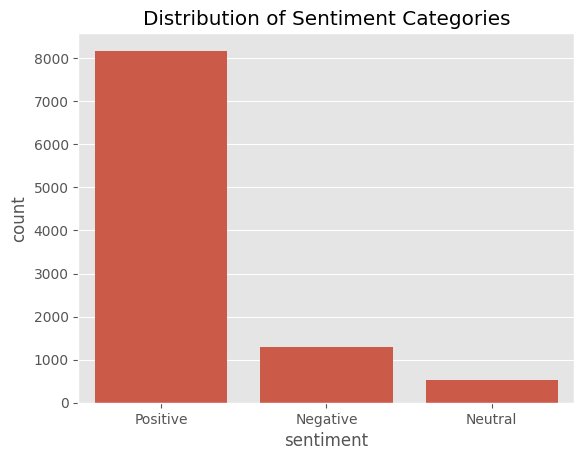

In [ ]:
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiment Categories')
plt.show()

In [ ]:
# Group by 'appVersion' and calculate the mean score
average_score_per_version = df.groupby('appVersion')['score'].mean().reset_index()

# Display the top 10 app versions with the highest average scores
top_versions = average_score_per_version.sort_values(by='score', ascending=False).head(10)
top_versions

,appVersion,score
22,5.1.3,5.000000
11,1.9.3,5.000000
2,1.2.1,5.000000
13,1.9.7,5.000000
4,1.4.9,5.000000
5,1.9.0,5.000000
29,6.0.0,4.385417
28,5.4.0,4.336987
17,5.0.0,4.333333
8,1.9.19,4.250000


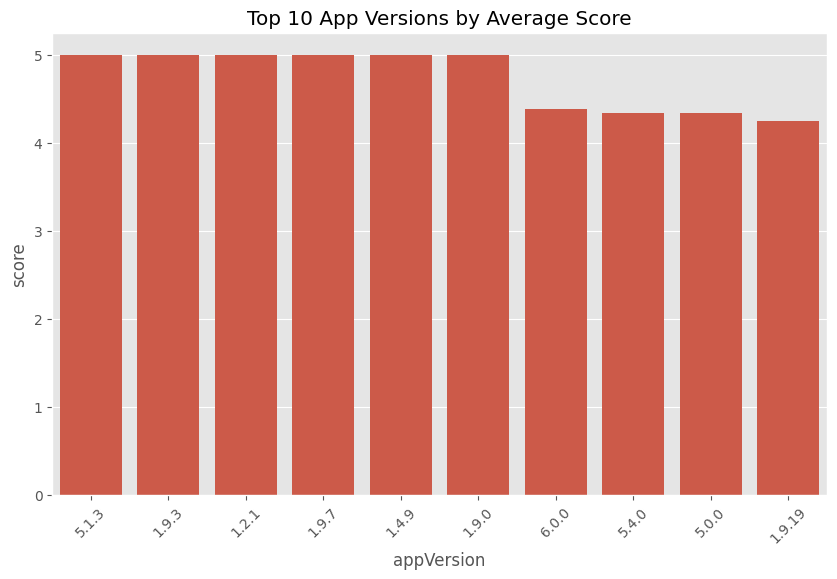

In [ ]:
# Plot the average score per app version
plt.figure(figsize=(10,6))
sns.barplot(x='appVersion', y='score', data=top_versions)
plt.xticks(rotation=45)
plt.title('Top 10 App Versions by Average Score')
plt.show()

In [ ]:
# Group by sentiment category and calculate the average thumbs-up count
thumbs_up_analysis = df.groupby('sentiment')['thumbsUpCount'].mean().reset_index()

# Display thumbs-up analysis
thumbs_up_analysis

,sentiment,thumbsUpCount
0,Negative,1.124138
1,Neutral,0.538314
2,Positive,0.246299


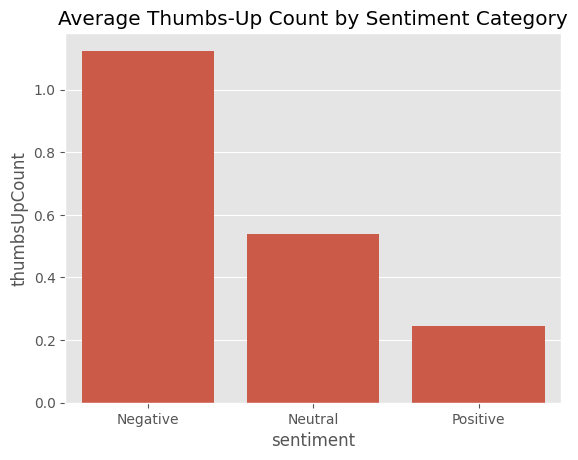

In [ ]:
# Plot thumbs-up analysis by sentiment category
sns.barplot(x='sentiment', y='thumbsUpCount', data=thumbs_up_analysis)
plt.title('Average Thumbs-Up Count by Sentiment Category')
plt.show()

In [ ]:
# Calculate the frequency of reviews per app version
version_frequency = df['appVersion'].value_counts().reset_index()
version_frequency.columns = ['appVersion', 'review_count']

# Display the top 10 app versions with the highest number of reviews
version_frequency.head(10)

,appVersion,review_count
0,5.4.0,6751
1,5.3.2,2081
2,5.3.1,562
3,5.3.0,180
4,5.2.1,160
5,6.0.0,96
6,1.10.1,86
7,1.9.11,10
8,1.9.19,8
9,5.2.0,7


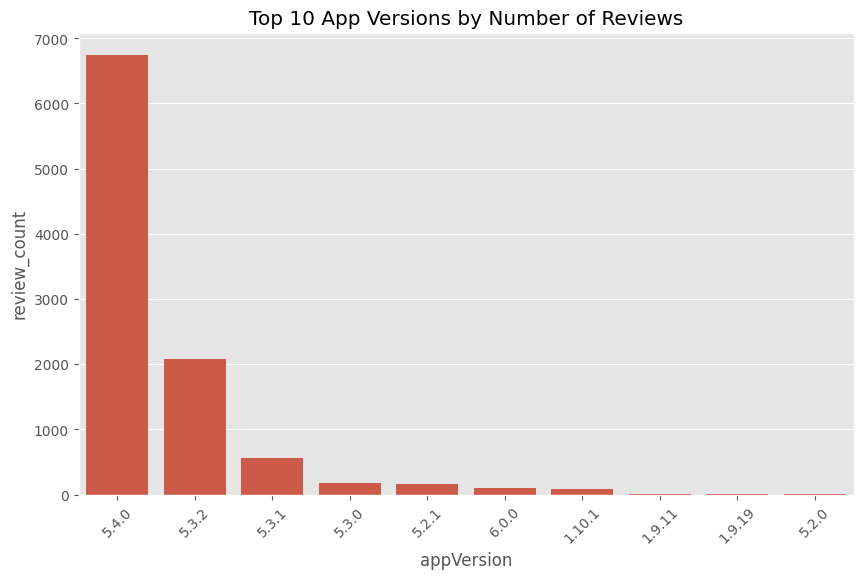

In [ ]:
# Plot the frequency of reviews per app version
plt.figure(figsize=(10,6))
sns.barplot(x='appVersion', y='review_count', data=version_frequency.head(10))
plt.xticks(rotation=45)
plt.title('Top 10 App Versions by Number of Reviews')
plt.show()

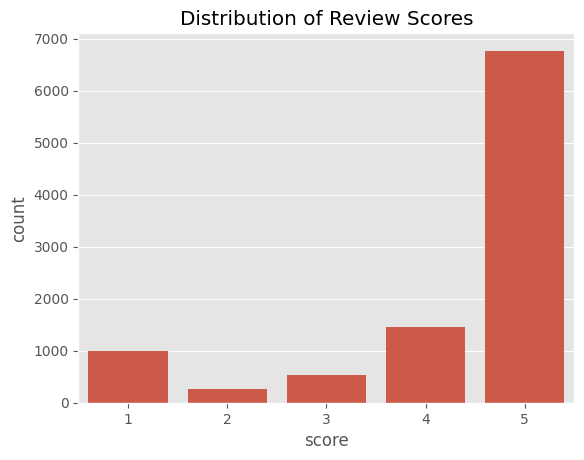

In [ ]:
# Plot the distribution of review scores
sns.countplot(x='score', data=df)
plt.title('Distribution of Review Scores')
plt.show()

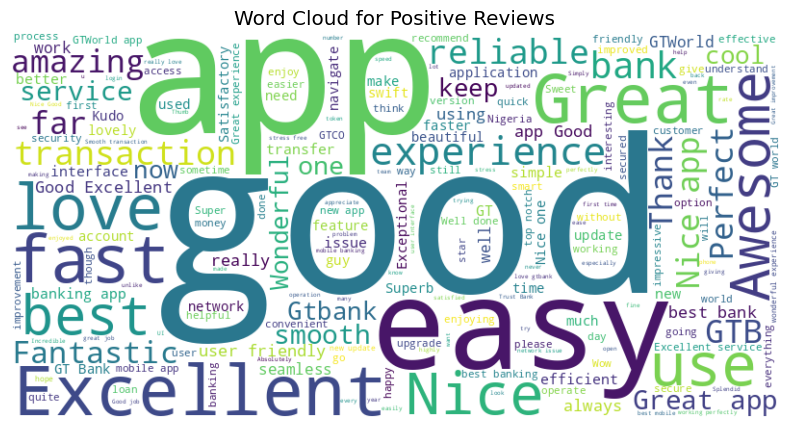

In [ ]:
from wordcloud import WordCloud

# Filter positive and reviews
positive_reviews = df[df['sentiment'] == 'Positive']['cleaned_content']

# Create word clouds for positive reviews
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_reviews))

# Plot the word cloud for positive reviews
plt.figure(figsize=(10,5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()


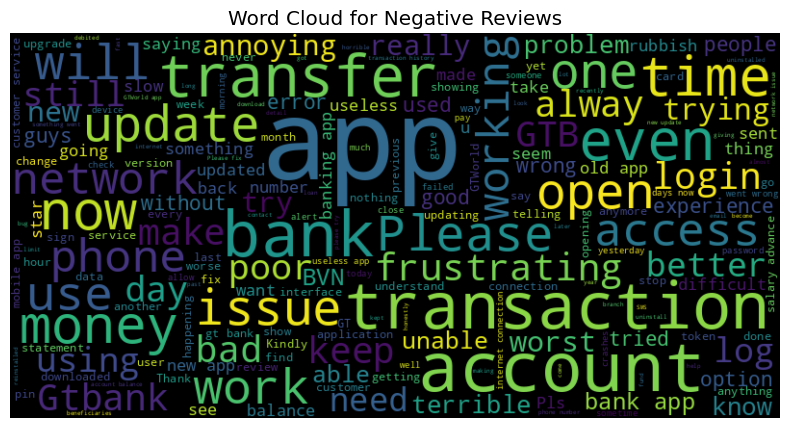

In [ ]:
# Filter negative reviews
negative_reviews = df[df['sentiment'] == 'Negative']['cleaned_content']

# Create word clouds for negative reviews
negative_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(negative_reviews))

# Plot the word cloud for negative reviews
plt.figure(figsize=(10,5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

<ipython-input-138-91e159a8cb5d>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_reviews = df.resample('M').size()


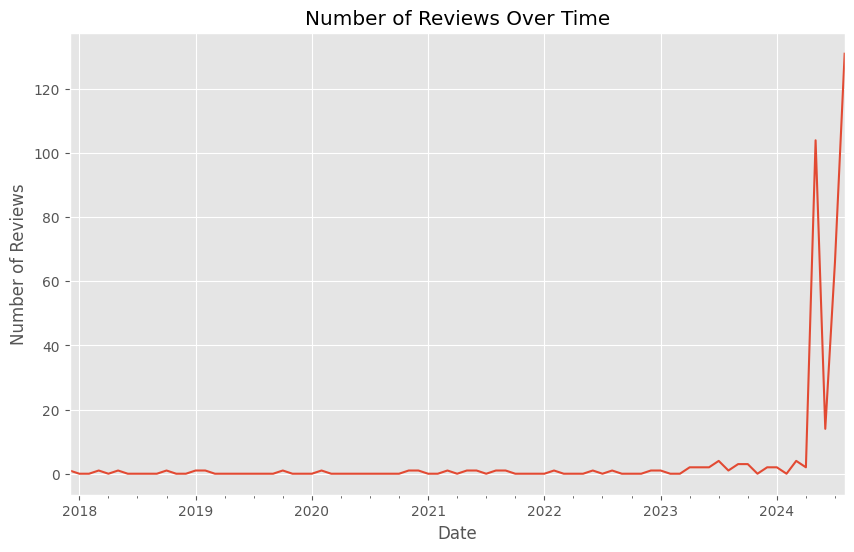

In [ ]:
df['at'] = pd.to_datetime(df['repliedAt']) # Assumed the column is 'review_date', replace with actual name if different
df.set_index('at', inplace=True)

# Resample by month and count reviews
monthly_reviews = df.resample('M').size()

# Plot the trend of reviews over time
plt.figure(figsize=(10,6))
monthly_reviews.plot()
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

Correlation between score and thumbs-up count: -0.02822899014626433


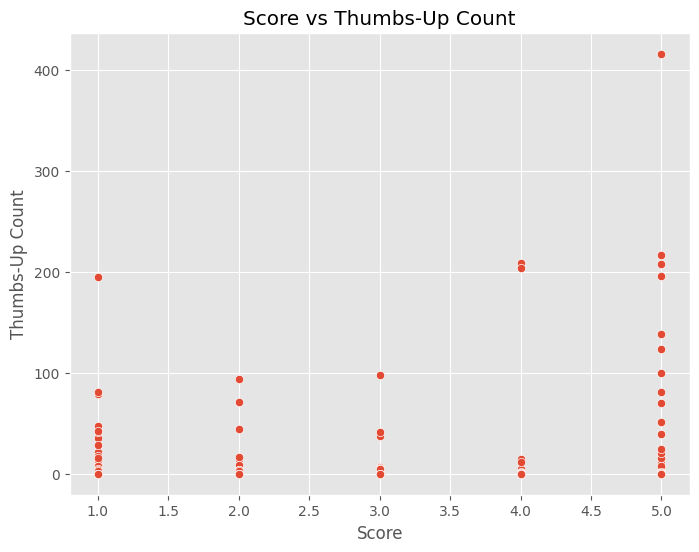

In [ ]:
# Calculate the correlation between score and thumbsUpCount
correlation = df['score'].corr(df['thumbsUpCount'])
print(f"Correlation between score and thumbs-up count: {correlation}")

# Plot a scatter plot to visualize the relationship between score and thumbs-up count
plt.figure(figsize=(8, 6))
sns.scatterplot(x='score', y='thumbsUpCount', data=df)
plt.title('Score vs Thumbs-Up Count')
plt.xlabel('Score')
plt.ylabel('Thumbs-Up Count')
plt.show()

In [ ]:
# Calculate word count and character count for each review
df['word_count'] = df['content'].apply(lambda x: len(x.split()))
df['char_count'] = df['content'].apply(lambda x: len(x))

# Display average word and character count by sentiment category
word_char_analysis = df.groupby('sentiment').agg({
    'word_count': 'mean',
    'char_count': 'mean'
}).reset_index()

word_char_analysis

,sentiment,word_count,char_count
0,Negative,25.390038,136.308046
1,Neutral,12.823755,67.103448
2,Positive,5.082467,26.970880


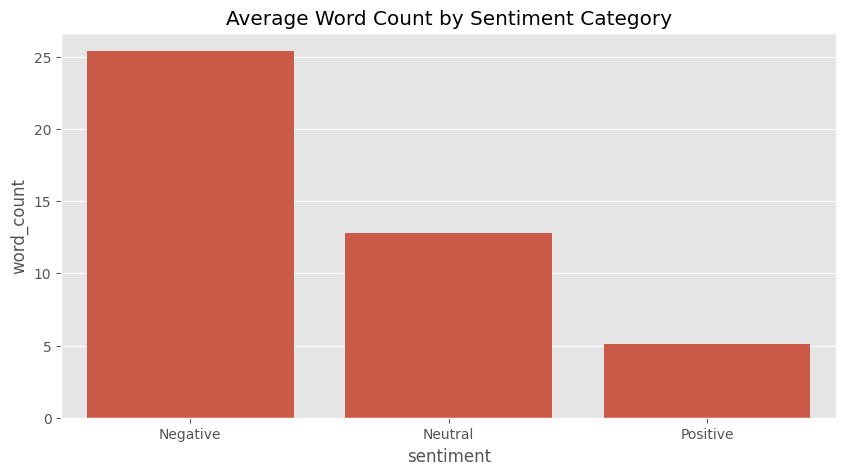

In [ ]:
# Plot word and character count by sentiment category
plt.figure(figsize=(10, 5))
sns.barplot(x='sentiment', y='word_count', data=word_char_analysis)
plt.title('Average Word Count by Sentiment Category')
plt.show()

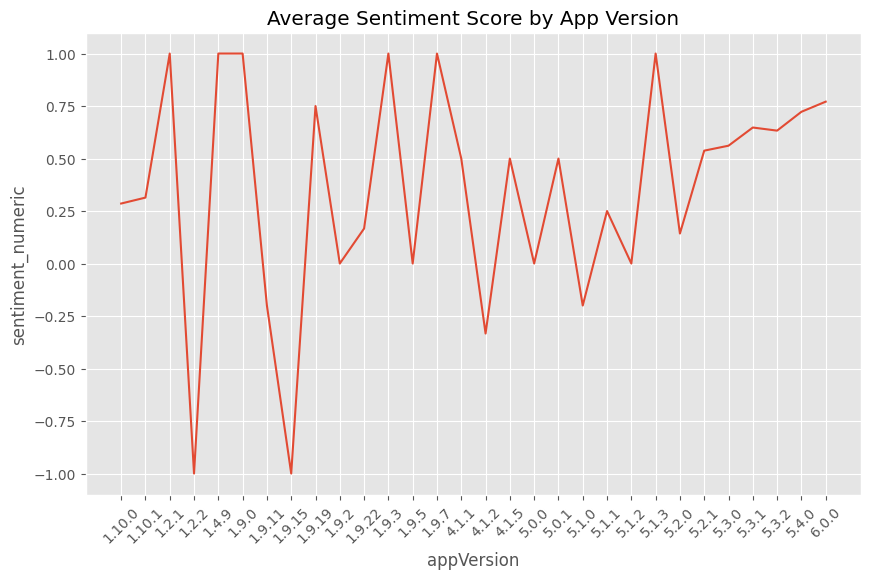

In [ ]:
# Calculate the average sentiment score by app version
# Convert 'sentiment' to numeric representation
sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['sentiment_numeric'] = df['sentiment'].map(sentiment_mapping)

sentiment_by_version = df.groupby('appVersion')['sentiment_numeric'].mean().reset_index()

# Plot the sentiment score for each app version
plt.figure(figsize=(10, 6))
sns.lineplot(x='appVersion', y='sentiment_numeric', data=sentiment_by_version)
plt.xticks(rotation=45)
plt.title('Average Sentiment Score by App Version')
plt.show()

In [ ]:
# Group by app version and sentiment category
version_sentiment_analysis = df.groupby(['appVersion', 'sentiment']).size().unstack(fill_value=0)

# Calculate the percentage of positive and negative reviews for each app version
version_sentiment_analysis['Total'] = version_sentiment_analysis.sum(axis=1)
version_sentiment_analysis['Positive%'] = version_sentiment_analysis['Positive'] / version_sentiment_analysis['Total'] * 100
version_sentiment_analysis['Negative%'] = version_sentiment_analysis['Negative'] / version_sentiment_analysis['Total'] * 100

# Select the top 5 app versions with the highest percentage of positive reviews
# and store them in a separate DataFrame
top_5_versions = version_sentiment_analysis[['Positive%', 'Negative%']].sort_values(by='Positive%', ascending=False).head(5)


# Display the top 5 app versions with the highest percentage of positive reviews
top_5_versions

sentiment,Positive%,Negative%
appVersion,,
1.9.3,100.0,0.0
1.2.1,100.0,0.0
5.1.3,100.0,0.0
1.4.9,100.0,0.0
1.9.0,100.0,0.0


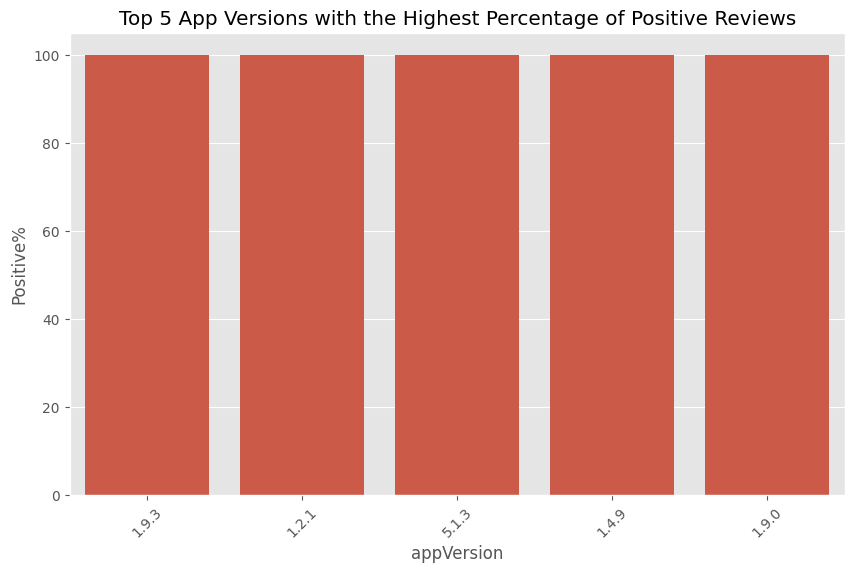

In [ ]:
# Plot the top 5 app versions with the highest percentage of positive reviews
# Use the index of the top_5_versions DataFrame for the x-axis labels
plt.figure(figsize=(10,6))
sns.barplot(x=top_5_versions.index, y='Positive%', data=top_5_versions) # Changed line: using top_5_versions.index and top_5_versions as data
plt.xticks(rotation=45)
plt.title('Top 5 App Versions with the Highest Percentage of Positive Reviews')
plt.show()

In [ ]:
# Group by app version and sentiment category
version_sentiment_analysis = df.groupby(['appVersion', 'sentiment']).size().unstack(fill_value=0)

# Calculate the percentage of positive and negative reviews for each app version
version_sentiment_analysis['Total'] = version_sentiment_analysis.sum(axis=1)
version_sentiment_analysis['Positive%'] = version_sentiment_analysis['Positive'] / version_sentiment_analysis['Total'] * 100
version_sentiment_analysis['Negative%'] = version_sentiment_analysis['Negative'] / version_sentiment_analysis['Total'] * 100

# Select the top 5 app versions with the highest percentage of negative reviews
# and store them in a separate DataFrame
top_5_negative_versions = version_sentiment_analysis[['Positive%', 'Negative%']].sort_values(by='Negative%', ascending=False).head(5)  # Changed to sort by 'Negative%'

# Display the top 5 app versions with the highest percentage of negative reviews
top_5_negative_versions

sentiment,Positive%,Negative%
appVersion,,
1.2.2,0.000000,100.000000
1.9.15,0.000000,100.000000
4.1.2,33.333333,66.666667
5.1.0,40.000000,60.000000
1.9.11,40.000000,60.000000


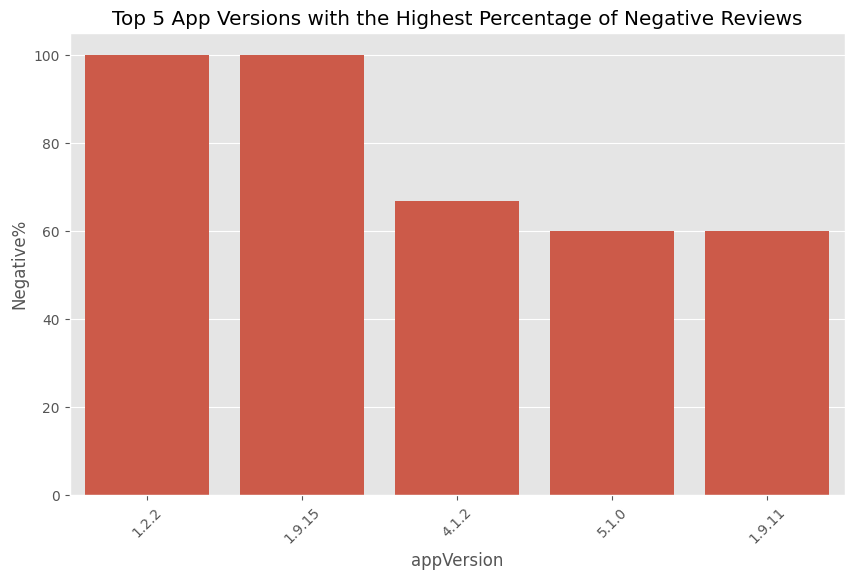

In [ ]:
# Plot the top 5 app versions with the highest percentage of negative reviews
# Use the index of the top_5_negative_versions DataFrame for the x-axis labels
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_negative_versions.index, y='Negative%', data=top_5_negative_versions)  # Changed to plot 'Negative%' and use top_5_negative_versions
plt.xticks(rotation=45)
plt.title('Top 5 App Versions with the Highest Percentage of Negative Reviews')  # Changed title
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to create and display n-grams (e.g., bigrams or trigrams)
def generate_ngrams(text_series, n=2):
    vec = CountVectorizer(ngram_range=(n, n)).fit(text_series)
    bag_of_words = vec.transform(text_series)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq

# Extract bigrams for positive reviews
positive_bigrams = generate_ngrams(df[df['sentiment'] == 'Positive']['content'], 2)
positive_bigrams[:10]  # Top 10 bigrams in positive reviews

[('very good', 587),
 ('the app', 447),
 ('easy to', 373),
 ('app is', 334),
 ('to use', 328),
 ('all good', 320),
 ('the best', 266),
 ('fast and', 255),
 ('this app', 238),
 ('good app', 206)]

In [ ]:
# Extract bigrams for negative reviews
negative_bigrams = generate_ngrams(df[df['sentiment'] == 'Negative']['content'], 2)
negative_bigrams[:10] # Top 10 bigrams in negative reviews

[('the app', 377),
 ('this app', 210),
 ('app is', 174),
 ('is not', 91),
 ('this is', 81),
 ('on my', 80),
 ('my account', 79),
 ('to the', 73),
 ('my phone', 65),
 ('on the', 64)]

In [ ]:
# Analyze the proportion of replies to each sentiment category
reply_analysis = df.groupby('sentiment')['replyContent'].apply(lambda x: (x != 'No Reply').mean()).reset_index()
reply_analysis.columns = ['sentiment', 'reply_rate']

# Display the reply rate by sentiment category
reply_analysis

,sentiment,reply_rate
0,Negative,0.151724
1,Neutral,0.057471
2,Positive,0.016395


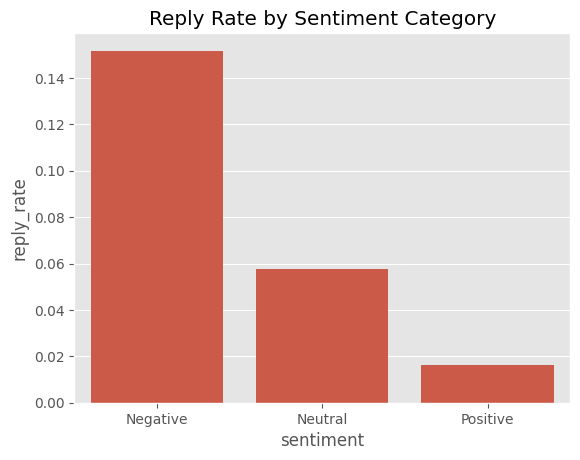

In [ ]:
# Plot the reply rate by sentiment category
sns.barplot(x='sentiment', y='reply_rate', data=reply_analysis)
plt.title('Reply Rate by Sentiment Category')
plt.show()

In [ ]:
# Filter out rows where there was no reply
replied_reviews = df[df['replyContent'] != 'No Reply'].copy()

# Convert 'repliedAt' to datetime
replied_reviews['repliedAt'] = pd.to_datetime(replied_reviews['repliedAt'], errors='coerce')

# Calculate time to response
replied_reviews['response_time'] = (replied_reviews['repliedAt'] - replied_reviews['repliedAt']).dt.days

# Display the average response time for each sentiment category
avg_response_time = replied_reviews.groupby('sentiment')['response_time'].mean().reset_index()
avg_response_time

,sentiment,response_time
0,Negative,0.0
1,Neutral,0.0
2,Positive,0.0


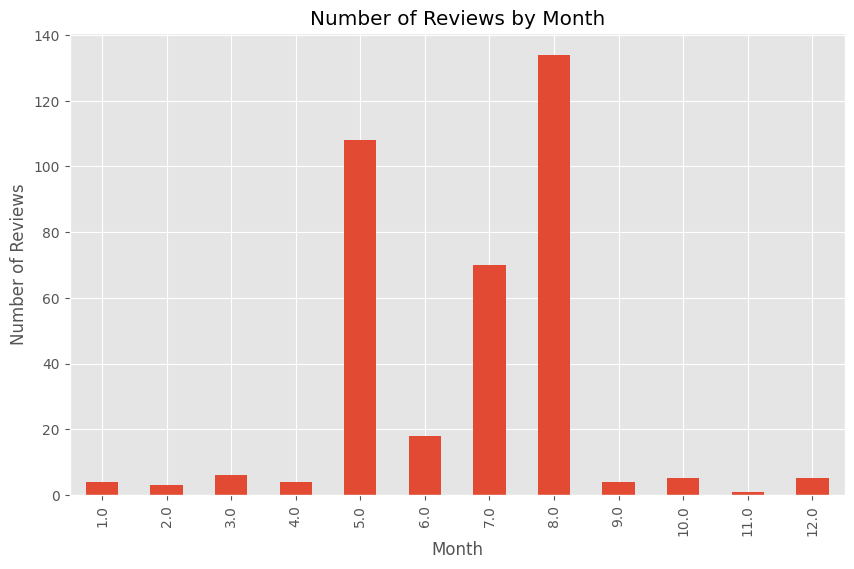

In [ ]:
# Extract month from 'at' column
df['month'] = df.index.month

# Plot the number of reviews by month
plt.figure(figsize=(10, 6))
df['month'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Reviews by Month')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.show()

In [ ]:
df.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'replyContent', 'repliedAt',
       'appVersion', 'cleaned_content', 'sentiment_score', 'sentiment',
       'repliedt', 'word_count', 'char_count', 'sentiment_numeric', 'month'],
      dtype='object')

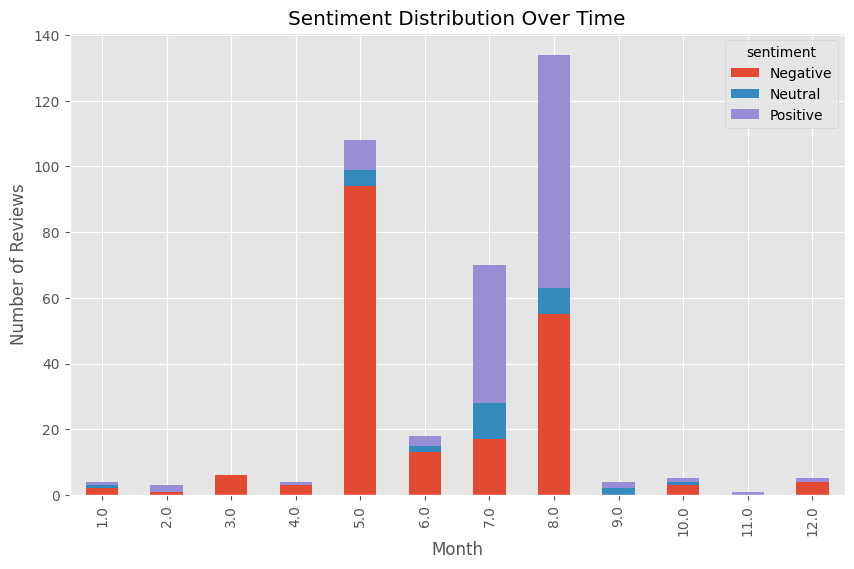

In [ ]:
# Sentiment distribution over time (by month)
sentiment_over_time = df.groupby('month')['sentiment'].value_counts().unstack().fillna(0)
sentiment_over_time.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment Distribution Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply TF-IDF to extract the most frequent keywords
tfidf = TfidfVectorizer(stop_words='english', max_features=10)
tfidf_matrix = tfidf.fit_transform(df['cleaned_content'])
top_keywords = tfidf.get_feature_names_out()

print("Top keywords from reviews:")
print(top_keywords)

Top keywords from reviews:
['app' 'bank' 'best' 'easy' 'excellent' 'fast' 'good' 'great' 'nice' 'use']


In [ ]:
# Find the top 10 reviews with the most thumbs up
top_thumbs_up = df[['content', 'thumbsUpCount', 'sentiment']].sort_values(by='thumbsUpCount', ascending=False).head(10)
top_thumbs_up

,content,thumbsUpCount,sentiment
at,,,
NaT,"I've been using GTBANK APP for a while now, an...",416,Positive
NaT,"So far, my experience with GTBank app both old...",217,Positive
NaT,As soon as I migrated to this present app it t...,209,Positive
NaT,I have now been using the app for a few years ...,208,Positive
NaT,This app and the upgrade in it are fantastic; ...,204,Positive
NaT,I have been enjoying the app since I installed...,196,Positive
2024-05-30 15:10:17,"After the recent update, it just started malfu...",195,Negative
NaT,Forget!!! I give it to GTB with their consiste...,138,Negative
NaT,After several days of failed attempt to transa...,124,Negative


In [ ]:
 from sklearn.decomposition import LatentDirichletAllocation

# Vectorize the review content
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['cleaned_content'])

# Apply LDA to discover topics
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

# Display topics
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx+1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Topic 1:
['faster', 'beautiful', 'experience', 'better', 'far', 'cool', 'fast', 'reliable', 'app', 'good']
Topic 2:
['update', 'superb', 'issues', 'transfer', 'bank', 'just', 'account', 'bad', 'network', 'app']
Topic 3:
['exceptional', 'lovely', 'service', 'user', 'friendly', 'wonderful', 'app', 'smooth', 'love', 'excellent']
Topic 4:
['experience', 'banking', 'fast', 'bank', 'use', 'best', 'app', 'easy', 'nice', 'great']
Topic 5:
['experience', 'super', 'okay', 'efficient', 'app', 'seamless', 'amazing', 'fantastic', 'perfect', 'awesome']


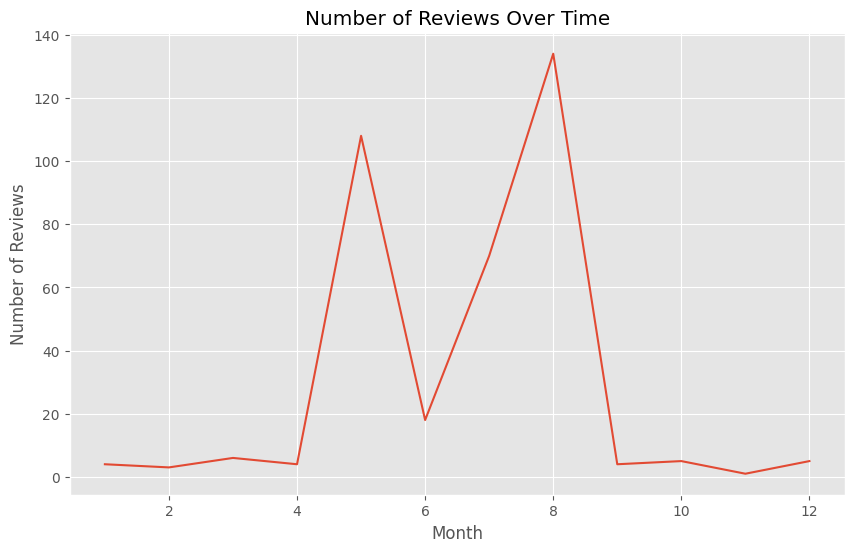

In [ ]:
# Plot number of reviews over time (by month)
reviews_per_month = df['month'].value_counts().sort_index()
reviews_per_month.plot(kind='line', figsize=(10, 6))
plt.title('Number of Reviews Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.show()